In [1]:
from sporgboost.forests import *
from sklearn.metrics import roc_auc_score
from get_data import load
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_iris
from sporgboost.preprocessing import onehot_encode
X, y = load_iris(return_X_y=True)

# y = onehot_encode(y)

In [4]:
from sklearn.ensemble import BaggingClassifier
from sporgboost.trees import *
rf = BaggingClassifier(base_estimator=AxisAlignedDecisionTree(n_classes=3), n_estimators=500)

TypeError: __init__() got an unexpected keyword argument 'n_classes'

In [3]:
rf.fit(X, y)

IndexError: tuple index out of range

In [2]:
from sporgboost.forests import RandomForest
rf = RandomForest()

In [3]:
rf.fit(X, y)

In [4]:
1 + 2

3

In [5]:
rf.predict(X)

In [4]:
%timeit rf.predict_proba(X)

In [4]:
rf.predict(X)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [3]:
aa.fit(X, y)
sr.fit(X, y)
rot.fit(X, y)

In [5]:
aa.predict(X)
sr.predict(X)
rot.predict(X)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

[Text(0.5, 0.9166666666666666, 'X[2] <= 2.45\ngini = 0.444\nsamples = 150\nvalue = [[100, 50]\n[100, 50]\n[100, 50]]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [[0, 50]\n[50, 0]\n[50, 0]]'),
 Text(0.5769230769230769, 0.75, 'X[3] <= 1.75\ngini = 0.333\nsamples = 100\nvalue = [[100, 0]\n[50, 50]\n[50, 50]]'),
 Text(0.3076923076923077, 0.5833333333333334, 'X[2] <= 4.95\ngini = 0.112\nsamples = 54\nvalue = [[54, 0]\n[5, 49]\n[49, 5]]'),
 Text(0.15384615384615385, 0.4166666666666667, 'X[3] <= 1.65\ngini = 0.027\nsamples = 48\nvalue = [[48, 0]\n[1, 47]\n[47, 1]]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [[47, 0]\n[0, 47]\n[47, 0]]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [[1, 0]\n[1, 0]\n[0, 1]]'),
 Text(0.46153846153846156, 0.4166666666666667, 'X[3] <= 1.55\ngini = 0.296\nsamples = 6\nvalue = [[6, 0]\n[4, 2]\n[2, 4]]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [[3, 0]\n[3, 0]\n[0, 

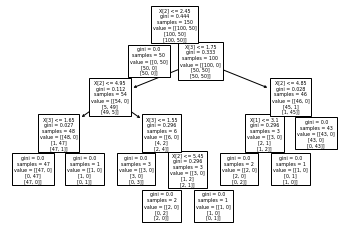

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
sk = DecisionTreeClassifier()
sk.fit(X, y)
plot_tree(sk)

In [ ]:
%timeit _predict_tree(tree, X, 3)

NameError: name '_predict' is not defined

In [4]:
tree = _grow_tree(X, y, proj = identity, max_depth = None)

c:\Users\Ed\OneDrive - Johns Hopkins\Desktop\Adv_ML_Project\sporgboost\common\_grow.py:36: NumbaWarning: Cannot cache compiled function "_grow_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(parallel=True, cache=True)


In [8]:
tree = _grow_tree(X, y, 2, 3, proj = sparse_random, max_depth = None)

TypeError: some keyword arguments unexpected

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=1234)

In [19]:
models = {
    # 'rf' : RandomForest(),
    # 'ab' : AdaBoost(),
    'sporf' : SPORF(d=2, s=3),
    'sporgboost' : SPORGBoost(d=2, s=3, max_depth=2),
    # 'rrf' : RotationalRandomForest(K=2),
    # 'rotboost' : RotBoost(K=2)
}

for k, m in models.items():
    print(f"Fitting {k}")
    m.fit(X_train, y_train)


Fitting sporf
Fitting sporgboost


In [22]:
%time
models['sporgboost'].fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

CPU times: total: 594 ms
Wall time: 597 ms


RandomForestClassifier()

In [13]:
rf.predict_proba(X_test)

[array([[0.31, 0.69],
        [0.21, 0.79],
        [0.37, 0.63],
        ...,
        [0.33, 0.67],
        [0.32, 0.68],
        [0.51, 0.49]]),
 array([[0.69, 0.31],
        [0.79, 0.21],
        [0.63, 0.37],
        ...,
        [0.67, 0.33],
        [0.68, 0.32],
        [0.49, 0.51]])]

In [14]:
roc_auc_score(y_test, rf.predict_proba(X_test)[1], multi_class='ovo')

0.9192514784504009

In [24]:
from sklearn.metrics import accuracy_score
# accuracy_score(y_test, rf.predict(X_test))

In [26]:
# Get AUC scores
auc = {key : accuracy_score(y_test, model.predict(X_test)) for key, model in models.items() if key in {'sporf','sporgboost'}}
auc

{'sporf': 0.7630681818181818, 'sporgboost': 0.6098863636363636}